<a href="https://colab.research.google.com/github/tommasorigon/CompStat/blob/main/notebook/un_B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit B.2 - Optimal scaling & adaptive Metropolis


In this unit we discuss several (adaptive) MCMC strategies that have been presented in the [**slides of unit B.1**](../slides/un_B1.pdf). We will implement these proposals using the "famous" **Pima indian dataset**. The purpose of this unit is mainly presenting the implementation of the various MCMC algorithms and not making "inference" about their general performance. Refer to the nice paper by [Chopin & Ridgway (2017)](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Leave-Pima-Indians-Alone--Binary-Regression-as-a-Benchmark/10.1214/16-STS581.full) for a more comprehensive discussion on this aspect. 

## The Pima indian dataset

In first place, let us load the `Pima.tr` and `Pima.te` datasets which are available in the `MASS` R package. As described in the documentation, this dataset includes:

> A population of women who were at least 21 years old, of Pima Indian heritage and living near Phoenix, Arizona, was tested for diabetes according to World Health Organization criteria. The data were collected by the US National Institute of Diabetes and Digestive and Kidney Diseases. We used the 532 complete records after dropping the (mainly missing) data on serum insulin.

See also the documentation of the `Pima.tr` and `Pima.te` datasets for a more comprehensive description of the involved variables. Firstly, we combine the training and test dataset into a single `data.frame` as follows:


In [1]:
Pima <- rbind(MASS::Pima.tr, MASS::Pima.te)

We are interested in modeling the probability of being diabetic (variable `type`) as a function of the covariates. We also **standardize the predictors**, because this usually improves the mixing, see [Gelman et al. ( 2008)](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full). As an **exercise** you can repeat the whole analysis using the original data.



In [2]:
y <- as.numeric(Pima$type == "Yes") # Binary outcome
X <- model.matrix(type ~ . - 1, data = Pima) # Design matrix
X <- cbind(1, scale(X)) # Standardize the design matrix, add the intercept

Let $\textbf{y} = (y_1,\dots,y_n)^\intercal$ be the vector of the observed **binary responses** (variable `type`) and let $\textbf{X}$ be the corresponding **design matrix** whose generic row is $\textbf{x}_i = (x_{i1},\dots,x_{ip})^\intercal$, for $i=1,\dots,n$. We employ a generalized linear model such that

$$
y_i \mid \pi_i \overset{\text{ind}}{\sim} \text{Bern}(\pi_i), \qquad \pi_i = g(\eta_i), \qquad \eta_i = \beta_1x_{i1} + \cdots + \beta_p x_{ip},
$$
where the link function $g(\cdot)$ is either the inverse logit transform (`plogis` function) or the cumulative distribution function of a standard normal (`pnorm` function).  We wish to estimate the parameter vector ${\bf \beta} = (\beta_1,\dots,\beta_p)^\intercal$. To fix the ideas, we are interested in the Bayesian counterpart of the following models for binary data:


In [3]:
# Probit model
fit_probit <- glm(type ~ X - 1, family = binomial(link = "probit"), data = Pima)
# Logit model
fit_logit <- glm(type ~ X - 1, family = binomial(link = "logit"), data = Pima)

The focus of this presentation is on the computational aspects, so we will employ a relatively **vague prior** centered at $0$, namely 

$$\beta \sim N(0, 100 I_p).$$ 

The reader should be aware that much better prior specification exist; see for example [Gelman et al. ( 2008)](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-4/A-weakly-informative-default-prior-distribution/10.1214/08-AOAS191.full). 

We now turn to the implementation of some basic quantity. In first place, we code the log-likelihood and the log-posterior functions. We consider here the **logistic** case.


In [4]:
# Loglikelihood of a logistic regression model
loglik <- function(beta, y, X) {
  eta <- c(X %*% beta)
  sum(y * eta - log(1 + exp(eta)))
}

# Logposterior
logpost <- function(beta, y, X) {
  loglik(beta, y, X) + sum(dnorm(beta, 0, 10, log = T))
}

## Metropolis-Hastings

The first algorithm we consider is a vanilla **Metropolis-Hastings** algorithm. Below we propose a relatively efficient implementation, which is very similar to the one employed in the [**Markdown of unit A.1**](un_A1.html), with the obvious modifications. 


In [5]:
# R represent the number of samples
# burn_in is the number of discarded samples
# S is the covariance matrix of the multivariate Gaussian proposal
RMH <- function(R, burn_in, y, X, S) {
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- rep(0, p) # Initial values
  logp <- logpost(beta, y, X)

  # Eigen-decomposition
  eig <- eigen(S, symmetric = TRUE)
  A1 <- t(eig$vectors) * sqrt(eig$values)

  # Starting the Gibbs sampling
  for (r in 1:(burn_in + R)) {
    beta_new <- beta + c(matrix(rnorm(p), 1, p) %*% A1)
    logp_new <- logpost(beta_new, y, X)
    alpha <- min(1, exp(logp_new - logp))
    if (runif(1) < alpha) {
      logp <- logp_new
      beta <- beta_new # Accept the value
    }
    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

We sample `R = 30000` values after a burn-in period of `30000` draws, for a total of `60000` iterations.  The performance of the algorithm (effective sample size) are stored in the `summary_tab` object. In this unit we will consider $5$ different MCMC algorithms, and we store their name as well. 



In [7]:
install.packages("coda")
library(coda)
R <- 30000 # Number of retained samples
burn_in <- 30000 # Burn-in period

# Summary table
summary_tab <- matrix(0, nrow = 5, ncol = 4)
colnames(summary_tab) <- c("Seconds", "Average ESS", "Average ESS per sec", "Average acceptance rate")
rownames(summary_tab) <- c("Vanilla MH", "Laplace MH", "Adaptive MH", "Metropolis within Gibbs", "Adaptive Metropolis within Gibbs")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In order to run the algorithm, we need to specify the **covariance matrix** `S` of the proposal distribution. In the absence of some sensible suggestion, we initially try $S = \text{diag}(10^{-3},\dots,10^{-3})$. This could (and will) be an poor choice, leading to a highly autocorrelated chain. We will explore alternative specifications for `S` later on. The final result is decent, but the mixing can be certainly improved. 



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  174.9   205.0   258.5   259.6   320.7   333.1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  90.06   93.56  119.31  122.76  146.43  171.52 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.7191  0.7191  0.7191  0.7191  0.7191  0.7191 

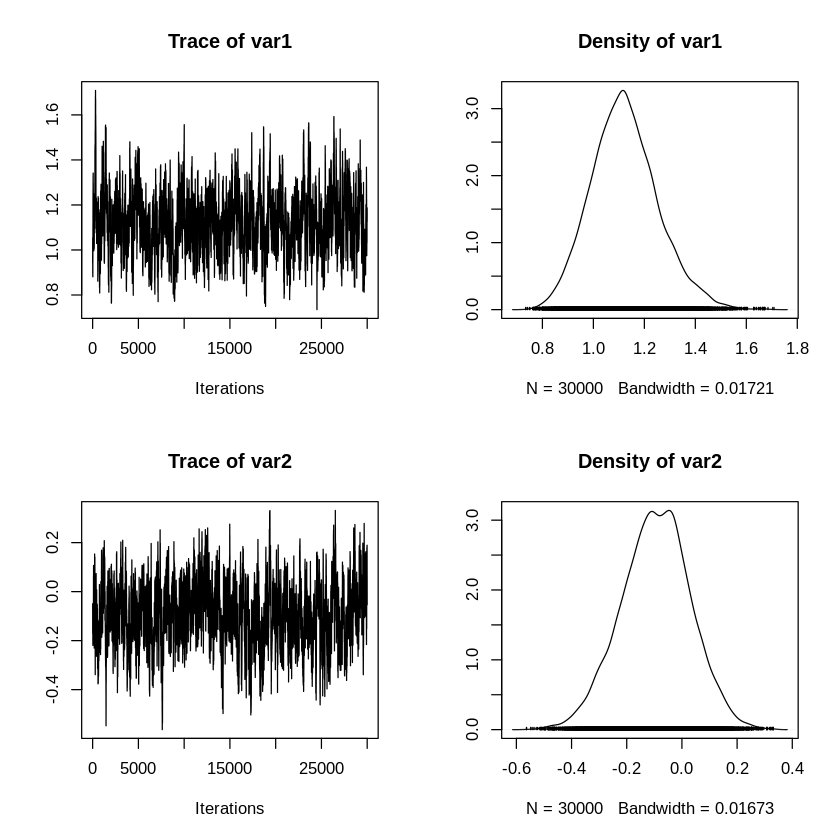

In [8]:
set.seed(123)

# Covariance matrix of the proposal
S <- diag(1e-3, ncol(X))

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(RMH(R, burn_in, y, X, S)) # Convert the matrix into a "coda" object
end.time <- Sys.time()
time_in_sec <- as.numeric(end.time - start.time)

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[1, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of a couple of parameters
plot(fit_MCMC[, 3:4])

### Laplace approximation


As suggested, among many others, by [Roberts and Rosenthal (2009)](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2009.06134), the **asymptotically optimal** covariance matrix `S` is equal to $2.38^2 \Sigma / p$, where $\Sigma$ is the unknown covariance matrix of the posterior distribution.  In this second approach, we obtain a rough estimate of $\Sigma$ using a **quadratic approximation** of the likelihood function. In the logistic case, this can be easily obtained with the `vcov` built-in R function. 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1097    1171    1203    1186    1211    1248 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24.05   24.78   24.95   25.34   25.62   27.34 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2726  0.2726  0.2726  0.2726  0.2726  0.2726 

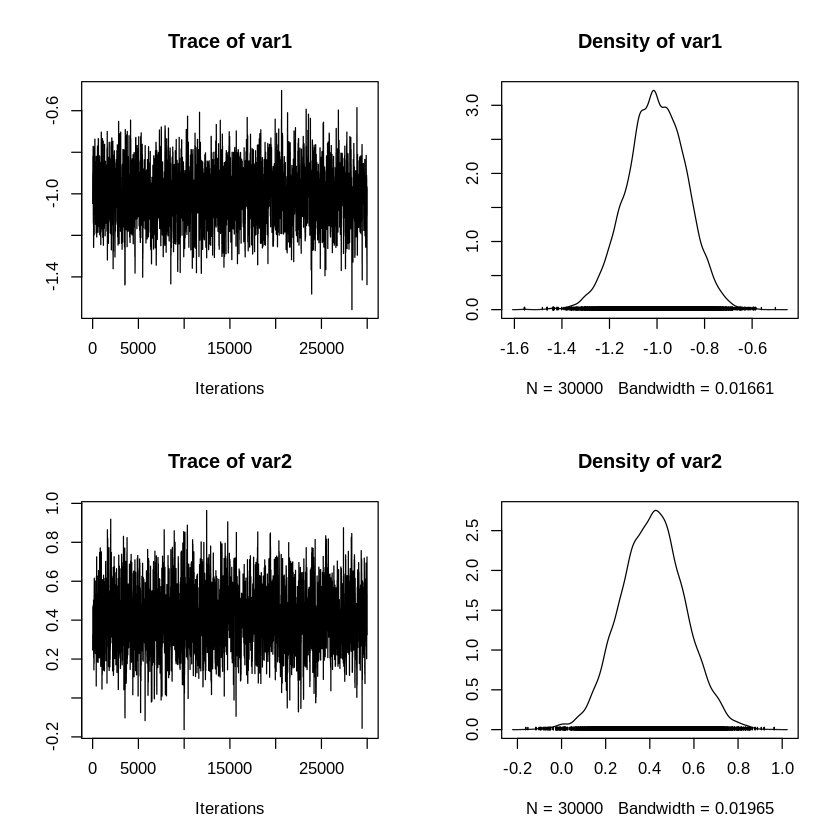

In [9]:
set.seed(123)

# Running the MCMC
start.time <- Sys.time()

# Covariance matrix is selected via laplace approximation
fit_logit <- glm(type ~ X - 1, family = binomial(link = "logit"), data = Pima)
p <- ncol(X)
S <- 2.38^2 * vcov(fit_logit) / p
# MCMC
fit_MCMC <- as.mcmc(RMH(R, burn_in, y, X, S)) # Convert the matrix into a "coda" object
end.time <- Sys.time()

time_in_sec <- as.numeric(end.time - start.time)

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[2, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Adaptive Metropolis-Hastings

We consider here a version of the **Adaptive Metropolis (AM)** algorithm of [Haario, Saksman, and Tamminem (2001)](https://projecteuclid.org/journals/bernoulli/volume-7/issue-2/An-adaptive-Metropolis-algorithm/bj/1080222083.full). The algorithm proceeds as in the standard Metropolis algorithm, but the covariance matrix of the proposal is updated at each iteration.

We use the following (adaptive) proposal distribution:

$$q_r({\bf \beta}^* \mid {\bf \beta}) \sim N({\bf \beta}, \:2.38^2 / p \: \Sigma_r + \epsilon  I_p),$$ 

where $\Sigma_r$ is the covariance matrix of the previously $r$ sampled values $\beta^{(1)},\dots,\beta^{(r)}$ and $\epsilon > 0$ is some small value that avoid degeneracies (i.e. the matrix $\Sigma_r$ must be invertible). Here, we will use $\epsilon = 10^{-6}$. Moreover, note that the following **recursive formula** holds true: 
$$
\Sigma_r = \frac{1}{r - 1}\sum_{j=1}^r(\beta^{(j)} - \bar{\beta}^{(r)})(\beta^{(j)} - \bar{\beta}^{(r)})^\intercal = \frac{r - 2}{r - 1}\Sigma_{r-1} + \frac{1}{r}(\beta^{(r)} - \bar{\beta}^{(r-1)})(\beta^{(r)} - \bar{\beta}^{(r-1)})^\intercal.
$$

where $\bar{\beta}^{(r)} = (r - 1)/r \bar{\beta}^{(r-1)} + \beta^{(r)} / r$ is the arithmetic means of the first $r$ sampled values. This facilitates the computation of $\Sigma_r$. The code for this AM algorithm is given in the following chunk.


In [10]:
# R represent the number of samples
# burn_in is the number of discarded samples
# S is the covariance matrix of the multivariate Gaussian proposal
RMH_Adaptive <- function(R, burn_in, y, X) {
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- rep(0, p) # Initial values
  logp <- logpost(beta, y, X)
  epsilon <- 1e-6 # Inital value for the covariance matrix

  # Initial matrix S
  S <- diag(epsilon, p)
  Sigma_r <- diag(0, p)
  mu_r <- beta

  for (r in 1:(burn_in + R)) {

    # Updating the covariance matrix
    if(r > 1){
      Sigma_r <- (r - 2) / (r - 1) * Sigma_r + tcrossprod(beta - mu_r) / r
      mu_r <- (r - 1) / r * mu_r + beta / r
      S <- 2.38^2 * Sigma_r / p + diag(epsilon, p)
    }

    # Eigen-decomposition
    eig <- eigen(S, symmetric = TRUE)
    A1 <- t(eig$vectors) * sqrt(eig$values)

    beta_new <- beta + c(matrix(rnorm(p), 1, p) %*% A1)
    logp_new <- logpost(beta_new, y, X)
    alpha <- min(1, exp(logp_new - logp))
    if (runif(1) < alpha) {
      logp <- logp_new
      beta <- beta_new # Accept the value
    }

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    977    1045    1149    1169    1279    1434 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.92   23.47   26.13   26.09   28.73   30.70 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.221   0.221   0.221   0.221   0.221   0.221 

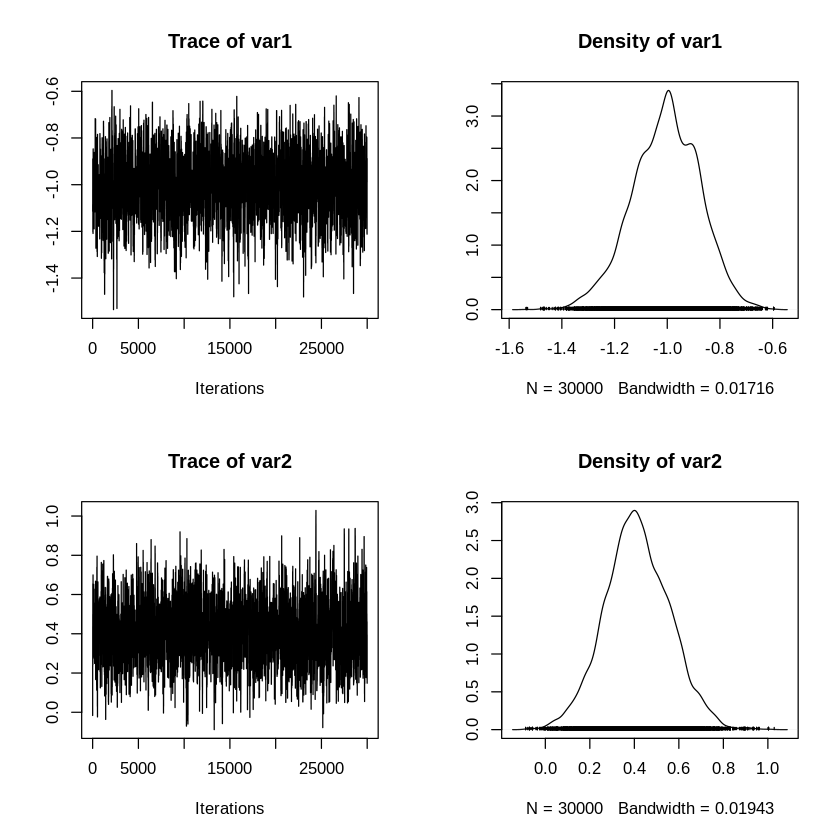

In [11]:
set.seed(123)

# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(RMH_Adaptive(R = R, burn_in = burn_in, y, X))
end.time <- Sys.time()

time_in_sec <- as.numeric(end.time - start.time)

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[3, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Metropolis within Gibbs 

We now consider a **Metropolis within Gibbs** strategy. The object `se` include the standard errors of the proposals for each parameter. The default choice  


In [15]:
RMH_Gibbs <- function(R, burn_in, y, X, se) {
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- beta_new <- rep(0, p) # Initial values
  logp <- logpost(beta, y, X)

  for (r in 1:(burn_in + R)) {
    for (j in 1:p) {
      beta_new[j] <- beta[j] + rnorm(1, 0, se[j])
      logp_new <- logpost(beta_new, y, X)
      alpha <- min(1, exp(logp_new - logp))
      if (runif(1) < alpha) {
        logp <- logp_new
        beta[j] <- beta_new[j] # Accept the value
      }
    }

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.02   36.43   37.37   37.57   40.58   44.21 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  678.6   740.1   802.8   814.8   824.1  1110.1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9682  0.9685  0.9697  0.9698  0.9710  0.9719 

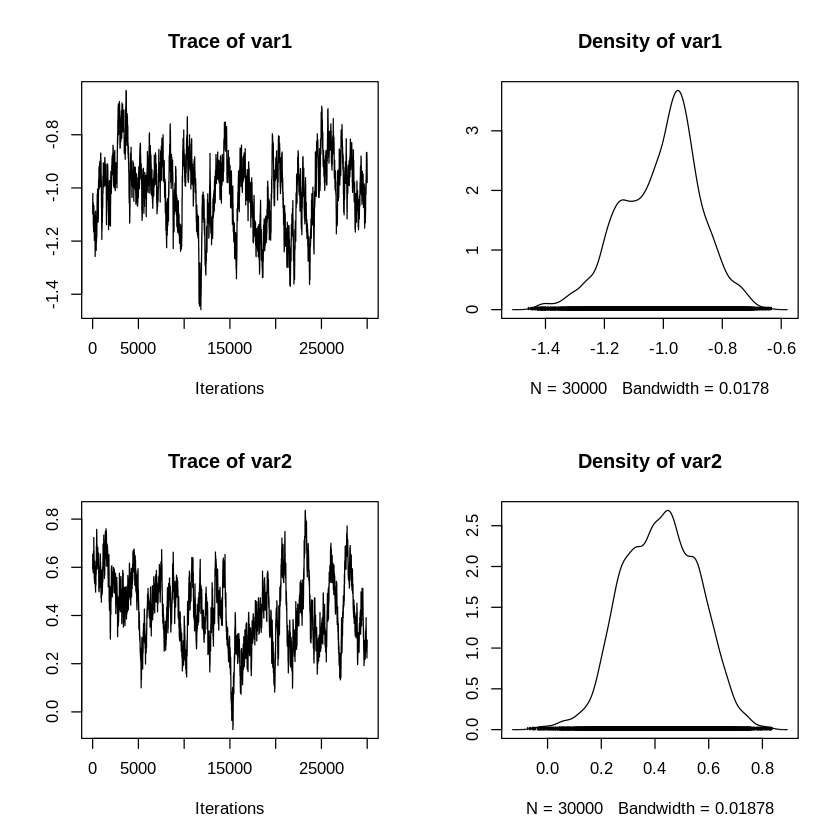

In [16]:
p <- ncol(X)
se <- sqrt(rep(1e-4, p))

set.seed(123)
# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(RMH_Gibbs(R = R, burn_in = burn_in, y, X, se)) # Convert the matrix into a "coda" object
end.time <- Sys.time()

time_in_sec <- as.numeric(end.time - start.time)

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[4, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Adaptive Metropolis within Gibbs 

Finally, we consider here the **Adaptive Metropolis within Gibbs** algorithm of [Roberts and Rosenthal (2009)](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2009.06134). The algorithm proceeds as in the standard Metropolis within Gibbs algorithm, but the standard errors of the proposal are updated at each iteration.

Every $50$ iterations, the algorithm increases or decreases the standard errors `se` according to the acceptance rate. As a rule of thumb, the "optimal" acceptance rate is about $0.44$ in the Metropolis within Gibbs case. 


In [17]:
RMH_Gibbs_Adaptive <- function(R, burn_in, y, X, target = 0.44) {
  
  p <- ncol(X)
  out <- matrix(0, R, p) # Initialize an empty matrix to store the values
  beta <- beta_new <- rep(0, p) # Initial values
  logp <- logpost(beta, y, X)

  epsilon <- rep(0, p) # Initial value
  accepted <- numeric(p) # Vector of accepted values
  batch <- 1

  for (r in 1:(burn_in + R)) {

    # Do we need to update the parameters?
    if (batch == 50) {
      for (j in 1:p) {
        # Adapting the standard errors
        if ((accepted[j] / 50) > target) {
          epsilon[j] <- epsilon[j] + min(0.01, sqrt(1 / r))
        } else {
          epsilon[j] <- epsilon[j] - min(0.01, sqrt(1 / r))
        }
      }
      # Restart the cycle - Erase everything
      accepted <- numeric(p) # Vector of accepted values
      batch <- 0
    }

    # Increment the batch
    batch <- batch + 1

    for (j in 1:p) {
      beta_new[j] <- beta[j] + rnorm(1, 0, exp(epsilon[j]))
      logp_new <- logpost(beta_new, y, X)
      alpha <- min(1, exp(logp_new - logp))
      if (runif(1) < alpha) {
        logp <- logp_new
        beta[j] <- beta_new[j] # Accept the value
        accepted[j] <- accepted[j] + 1
      }
    }

    # Store the values after the burn-in period
    if (r > burn_in) {
      out[r - burn_in, ] <- beta
    }
  }
  out
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  653.2   733.1  1021.5  1009.3  1293.6  1373.3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  21.84   23.19   31.43   32.76   41.07   45.93 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4451  0.4472  0.4479  0.4483  0.4494  0.4517 

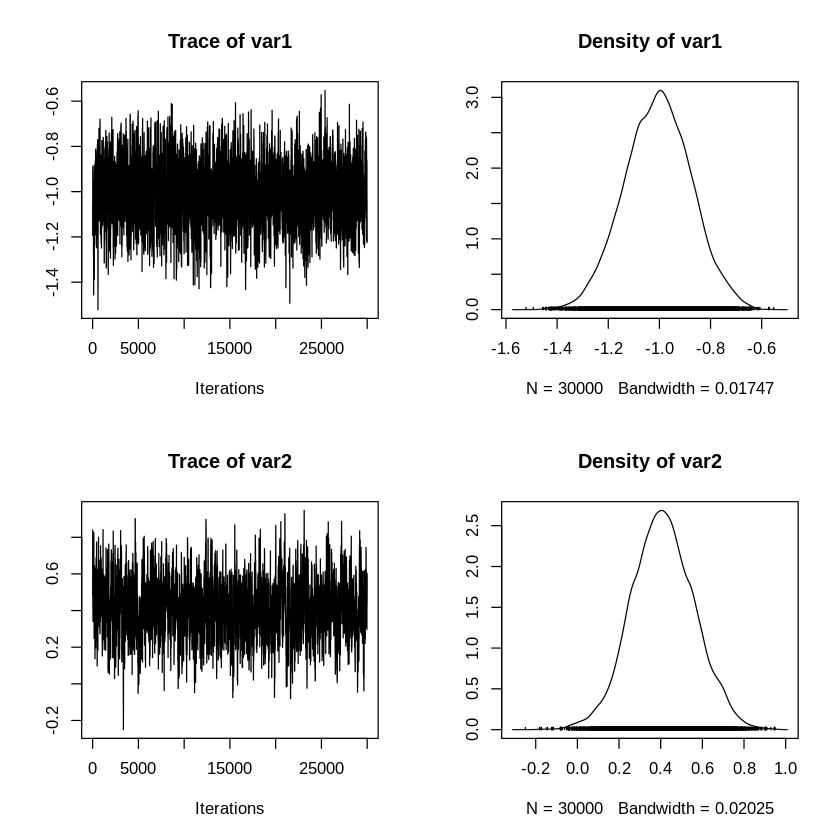

In [18]:
set.seed(123)
# Running the MCMC
start.time <- Sys.time()
fit_MCMC <- as.mcmc(RMH_Gibbs_Adaptive(R = R, burn_in = burn_in, y, X)) # Convert the matrix into a "coda" object
end.time <- Sys.time()

# Diagnostic
summary(effectiveSize(fit_MCMC)) # Effective sample size
summary(R / effectiveSize(fit_MCMC)) # Integrated autocorrelation time
summary(1 - rejectionRate(fit_MCMC)) # Acceptance rate

# Summary statistics
summary_tab[5, ] <- c(
  time_in_sec, mean(effectiveSize(fit_MCMC)),
  mean(effectiveSize(fit_MCMC)) / time_in_sec,
  1 - mean(rejectionRate(fit_MCMC))
)

# Traceplot of the intercept
plot(fit_MCMC[, 1:2])

## Summary statistics

The summary statistics of all the above algorithm are reported in the table below. 


In [21]:
knitr::kable(summary_tab, digits=2)



|                                 | Seconds| Average ESS| Average ESS per sec| Average acceptance rate|
|:--------------------------------|-------:|-----------:|-------------------:|-----------------------:|
|Vanilla MH                       |    3.38|      259.58|               76.80|                    0.72|
|Laplace MH                       |    3.28|     1185.77|              361.41|                    0.27|
|Adaptive MH                      |    7.04|     1169.07|              166.08|                    0.22|
|Metropolis within Gibbs          |   21.88|       37.57|                1.72|                    0.97|
|Adaptive Metropolis within Gibbs |   21.88|     1009.32|               46.13|                    0.45|